# Price and Product Tracker
---
---

This price and product tracker tracks product prices and product details from the German "Kleinanzeigen" website. It is optimized for the product type "cameras".

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# PART A: Data Acquisition
---

## Step 1: Ask user for product-name and keywords

This piece of code asks the user for a specific product on the German website "Kleinanzeigen". The program asks for user-inputs in **German** language.

**Example Product**: Nikon D 7500

In [85]:
product_input = str(input('Which camera are you looking for? (German)'))
i = 0
product = ''

for words in product_input.split(' '):
    if i == (len(product_input.split(' '))-1):
        product = product + words
    else: 
        product = product + words + '-'
    i += 1

## Step 2: Create product list for specific product

This code snippet creates a product list. The output is a csv file.

In [86]:
url = f'https://www.kleinanzeigen.de/s-{product}/k0'

# count number of subpages

p = requests.get(url)
website_data = BeautifulSoup(p.text, 'html.parser')
number_of_pages = len(website_data.find_all('a', {'class': 'pagination-page'}))

# get productlist

def get_productlist(url):
    
    # check each page
    for i in range(1,number_of_pages): 
        if i > 1: 
            url = f'https://www.kleinanzeigen.de/s-seite:{i}/{product}/k0'
        
        # get html content
        r = requests.get(url)
        html_content = BeautifulSoup(r.text, 'html.parser')
        
        # get productlist
        if i == 1:
            productslist = []
        results = html_content.find_all('div', {'class': 'aditem-main'})
        for item in results:
            if item.find('a', {'class': 'ellipsis'}) is not None:
                products = {
                    'title': item.find('a', {'class': 'ellipsis'}).text.replace(',','.'),
                    'price': int(item.find('p', {'class': 'aditem-main--middle--price-shipping--price'}).text.replace(' ','').replace('\n','').replace('.','').split("€")[0].replace('VB','0').replace('Zuverschenken','0').replace('"','0')),
                    'link': item.find('a', {'class': 'ellipsis'})['href']
                }
            productslist.append(products)
    return productslist

def create_dataframe(productslist):
    df_products = pd.DataFrame(productslist)
    df_products = df_products.sort_values(by=['price'])
    df_products = df_products.drop_duplicates()
    df_products.to_csv('products_all.csv', index=False)
    print('You are looking for: ' + product_input)
    print(len(df_products), 'products saved to products_all.csv-file in your folder.')
    return df_products

df_products = create_dataframe(get_productlist(url))

You are looking for: Nikon D 7500
48 products saved to products_all.csv-file in your folder.


## Step 3: Filter for key words in title (optional)

This code snippet creates a product list. The output is a csv file.

In [87]:
# optional: reduce list products with keywords

# keys_input = str(input('Which keywords would you like to filter for? (German, no comma, max. 4)'))
# i = 0
# keys = []

# for words in keys_input.split(' '):
#    keys += [words]

# print('Your keywords are:', keys)
# i = 0

# def find_keywords(df_products):
#    df_products_key = pd.DataFrame()
#    for entry in df_products['title']:
#        if keys[0] in entry or keys[1] in entry or keys[2] in entry or keys[3] in entry:
#            filtered_entry = df_products[df_products['title'] == entry]
#            df_products_key = pd.concat([df_products_key, filtered_entry], ignore_index=True)
#    df_products_key.to_csv('products_key_filter.csv', index=False)
#    print(len(df_products_key), 'filtered products saved to products_key_filter.csv-file in your folder.')

#find_keywords(df_products)

## Step 4: Get product description of each product

This code snippet fetches all products descriptions from each subpage. It takes around a minute to generate an output for around 50 items. The output is a csv file.

In [88]:
# copy DataFrame
df_products_detailed = df_products.copy()
df_products_detailed["description"] = ' '

# iteration through lines of DataFrame via iterrows()
for i, row in df_products.iterrows():
    if isinstance(row['link'], str):
        url = 'https://www.kleinanzeigen.de' + row['link']
        description = ''
        q = requests.get(url)
        if q.status_code == 200:
            html_content = BeautifulSoup(q.text, 'html.parser')
            if html_content.find('p', {'id': 'viewad-description-text'}) is not None:
                description = html_content.find('p', {'id': 'viewad-description-text'}).text.replace('\n', '').replace('  ', '')
        else:
            description = 'Error loading page'

        # add description in data.frame
        df_products_detailed.at[i, 'description'] = description

        # reduce server load
        time.sleep(1)

# save DataFrame
df_products_detailed.to_csv('products_with_details.csv', index=False)

print('Products details saved to products_with_details.csv-file in your folder.')

Products details saved to products_with_details.csv-file in your folder.


# Part B: Preprocessing
---

## Step 1: Regex - Extract information on shutter count and camera condition

#### Extract shutter count

As the shutter count ("Auslösezahl") is a good indicator for the condition of the camera, the product description is analyzed with regard to this aspect...

In [89]:
# extract shutter count function
def extract_shutter_count(description):
    match = re.search(r'(\d{4,})(\smal)?(\s+(A|a)+(us)((ge)?)+(lös))|(A|a)(uslösung)\w+?\s(\d{4})', description, re.IGNORECASE)

    if match:
        if match.group(1) == None: 
            return int(match.group(11)) # returns last group () = number
        else: 
            return int(match.group(1)) # returns first group () = number
    else:
        return None

# use function
df_products_detailed['shutter_count'] = df_products_detailed['description'].apply(extract_shutter_count)

# save csv file
df_products_detailed.to_csv('products_with_details.csv', index=False)
print('Shutter count extracted and saved to products_with_details.csv.')

# print relevant columns
print(df_products_detailed.drop('description', axis=1).drop('link', axis=1))

Shutter count extracted and saved to products_with_details.csv.
                                                title  price  shutter_count
30  Nikon D7500 Handbuch zur Kamera - Hardcover - ...     25            NaN
43  Nikon D7500 Das Handbuch zur Kamera. von Steph...     30            NaN
3     Nikon D7500 + 3 Objektive + EVOC Kamerarucksack    123            NaN
4                                  NIKON D7500 defekt    299            NaN
24                                   Nikon D7500 Body    480            NaN
17       Nikon D7500 Body inkl. Buch 9800 Auslösungen    490         9800.0
12                                       Nikon D 7500    499            NaN
49                                        Nikon D7500    525            NaN
38                       Nikon D7500 + Nikon 50mm 1.8    550            NaN
14              Nikon D7500 Spiegelreflex Kamera DSLR    555         6181.0
42  Nikon D7500 21Mp 4k Video w-Lan Bluetooth wie ...    579         2500.0
11                      

#### Check camera condition

Check for camera condition via **regex**

In [90]:
# check for good camera condition
#pattern = r'(\d{4}|((W|w)+(enig)+((e|en)?)))+((\smal)?)+(\s+(A|a)+(us)+((ge)?)+(lös))|(A|a)+(uslösung)+((\w+)?)+(\s)+(\d{4})|(wenig|kaum|nie|nicht|selten)+(\s)+(genutzt|benutzt|verwendet|fotografiert)'
pattern = r'(\d{1,5}(?:[\.,]?\d{1,3})?)\s?(Auslösungen?|Bilder?|Fotos?)(\s?(wenig|kaum|nie|selten|nicht|fast|geringe)\s?(genutzt|verwendet|gemacht|fotografiert)?)?'

def check_condition(description):
    if len(re.findall(pattern, description)) != 0:
        return(True)
    else: 
        return(False)

df_products_detailed['new?'] = df_products_detailed['description'].apply(check_condition)

# save csv file
df_products_detailed.to_csv('products_with_details.csv', index=False)
print('Condition extracted and saved to products_with_details.csv.')

# print relevant columns
#print(df_products_detailed.drop('description', axis=1).drop('link', axis=1))


Condition extracted and saved to products_with_details.csv.


#### Show products that are new (Plot)

In [91]:
df_new_products = df_products_detailed[df_products_detailed['new?'] == True]

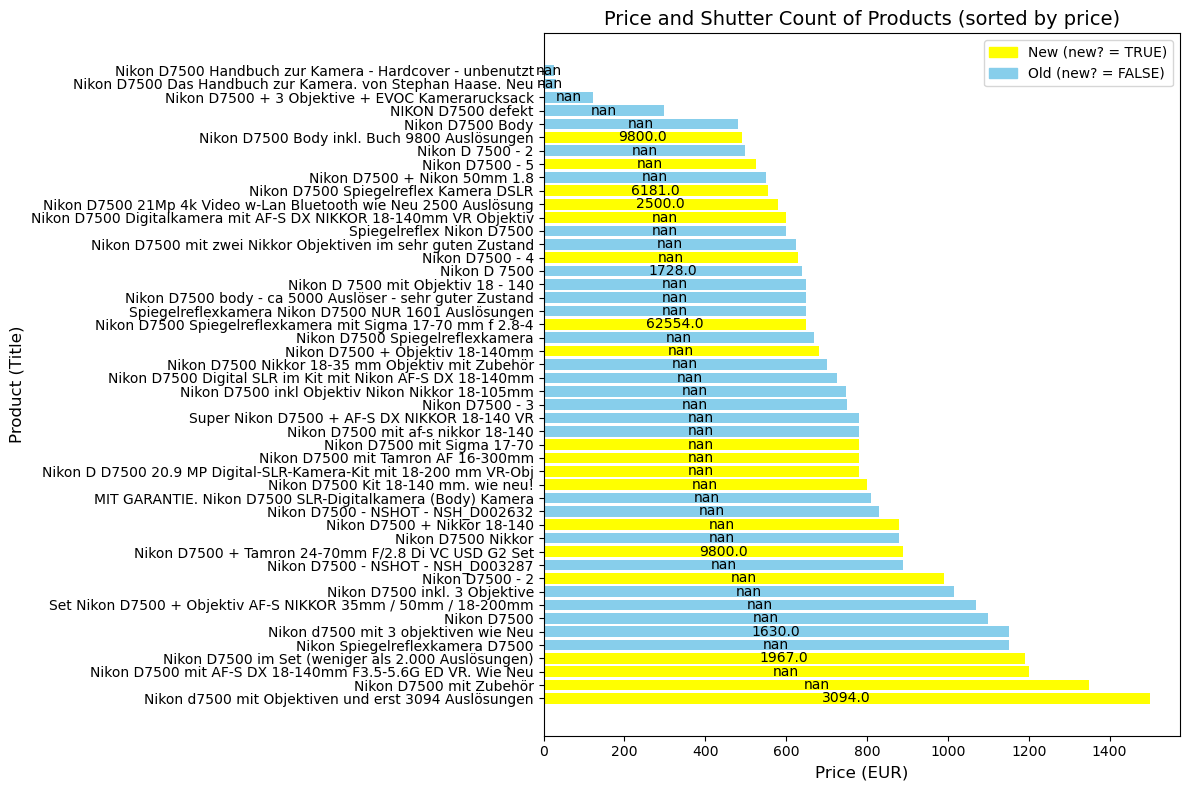

In [92]:
# Make sure 'shutter_count' is treated as numeric
df_products_detailed['shutter_count'] = pd.to_numeric(df_products_detailed['shutter_count'], errors='coerce')

# Sort df_products_detailed by price
df_products_detailed_sorted = df_products_detailed.sort_values(by='price', ascending=False)

# Create unique titles for products with the same name (if applicable)
df_products_detailed_sorted['unique_title'] = df_products_detailed_sorted.groupby('title').cumcount()
df_products_detailed_sorted['unique_title'] = df_products_detailed_sorted['unique_title'].apply(lambda x: f" - {x+1}" if x > 0 else "")

# Combine the original title with the unique number (if applicable)
df_products_detailed_sorted['unique_title'] = df_products_detailed_sorted['title'] + df_products_detailed_sorted['unique_title']

# Create figure and axes for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Color "new" products yellow, others blue
colors = ['yellow' if is_new else 'skyblue' for is_new in df_products_detailed_sorted['new?']]

# Create horizontal bar chart (Price on X-axis, Title on Y-axis)
bars = ax.barh(df_products_detailed_sorted['unique_title'], df_products_detailed_sorted['price'], color=colors)

# Add shutter_count in the middle of each bar
for bar, shutter_count in zip(bars, df_products_detailed_sorted['shutter_count']):
    xval = bar.get_width()  # Price (X-value)
    ax.text(xval / 2, bar.get_y() + bar.get_height() / 2,  # Center the text horizontally and vertically
            f'{shutter_count}', ha='center', va='center', fontsize=10, color='black')

# Set labels for the axes and the title of the plot
ax.set_xlabel('Price (EUR)', fontsize=12)
ax.set_ylabel('Product (Title)', fontsize=12)
ax.set_title('Price and Shutter Count of Products (sorted by price)', fontsize=14)

# Create color legend for "new" products
yellow_patch = mpatches.Patch(color='yellow', label='New (new? = TRUE)')
blue_patch = mpatches.Patch(color='skyblue', label='Old (new? = FALSE)')
ax.legend(handles=[yellow_patch, blue_patch], loc='upper right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


This graph shows all products sorted by price. 
In my example for the camera "Nikon D 7500" there is match between "new? = TRUE" and low values for the "shutter_count" which shows that my regex is working well :)

## Step 2: Tokenization, Stemming and Lemmatization

In [ ]:
# import spacy

# load German model
# nlp = spacy.load('de_core_news_sm')

# plan: find information on extras like lenses, ...

# Part C: Feature Engineering
---

...

# Part D: Model Building
---

...

# Part E: Model Evaluation
---

...


---
---

In [93]:
import watermark
print(watermark.watermark(packages="matplotlib"))

matplotlib: 3.9.2

